[View in Colaboratory](https://colab.research.google.com/github/LisbonKaggleMeetup/BikeSharingDemand/blob/master/notebooks/getting_started.ipynb)

# Download dataset (run only if you're using google colab!)

In [0]:
## This code imports the file from GDrive to the local VM
##  It only needs to run once
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# files to be imported in this format: (destination file path, file id)
files = [('./data.zip', '13rzCJwt-V7xNlc2zGqpSLJinvtBq4uYQ')]

# download and save each file in list "files"
for file_dest, file_id in files:
  downloaded = drive.CreateFile({'id': file_id})
  content = downloaded.GetContentFile(file_dest)
  
!unzip data.zip -d ./data


Archive:  data.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        
  inflating: ./data/sampleSubmission.csv  


# Bike sharing demand prediction challenge

### Import libraries

In [0]:
import pandas as pd
import numpy as np

### Load data

In [0]:
train = pd.read_csv("data/train.csv")
train.datetime=pd.to_datetime(train.datetime)
train = train.set_index("datetime").sort_index().rename(columns={'count':'total'})

In [9]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Data Preparation
## Missing values

In [17]:
train.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
total         0
dtype: int64

At first sight it seems there are no missing values.  
However if we count the number of records available in the first 20 days of January we should get 20*24=480. Instead we have:

In [38]:
train[:'2011-01-20'].count()

season        431
holiday       431
workingday    431
weather       431
temp          431
atemp         431
humidity      431
windspeed     431
casual        431
registered    431
total         431
weekday       431
dtype: int64

For some reason there are ~50 missing records!!

To visualize this we can count the number of records per day with the *resample* method. Note that if no data were missing we'd obtain the value 24 everywhere...

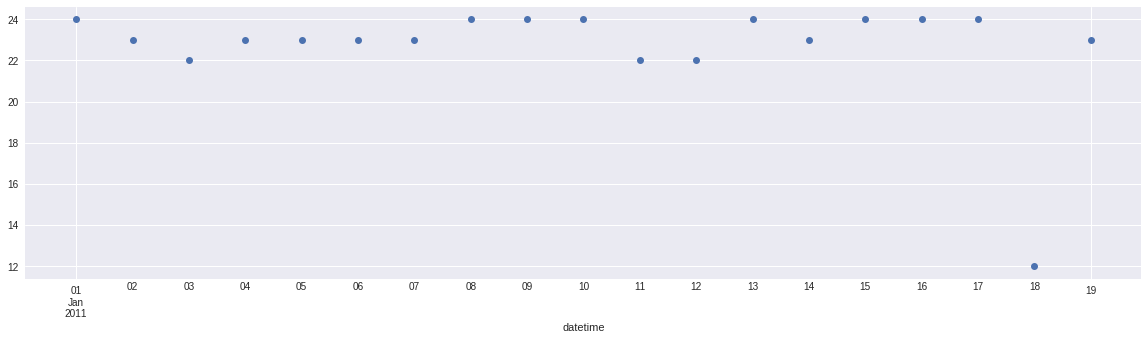

In [66]:
train_copy = train.copy()
train_copy['1']=1
train_copy.resample('D')
train_copy[:'2011-01-20'].resample('D').count()['1'].plot(figsize=(20,5),style='o')

Wow that's lots of days with missing records. According to this on the 18th of January there's only data for half the day, let's confirm:

In [67]:
train["2011-01-18"]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,weekday
datetime,,,,,,,,,,,,
2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,Tuesday
2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,Tuesday
2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,Tuesday
2011-01-18 15:00:00,1,0,1,2,9.02,11.365,87,11.0014,3,32,35,Tuesday
2011-01-18 16:00:00,1,0,1,2,9.02,11.365,87,12.9980,0,61,61,Tuesday
2011-01-18 17:00:00,1,0,1,2,9.02,11.365,82,12.9980,1,124,125,Tuesday
2011-01-18 18:00:00,1,0,1,2,9.02,11.365,80,11.0014,1,132,133,Tuesday
2011-01-18 19:00:00,1,0,1,2,9.02,11.365,80,8.9981,1,98,99,Tuesday
2011-01-18 20:00:00,1,0,1,2,9.02,13.635,87,0.0000,0,83,83,Tuesday


![oh_snap](https://media.giphy.com/media/ljoB50Kfk3ubm/giphy.gif "snap")

# Feature engineering

Add column with the week day

In [0]:
train['weekday'] = train.index.weekday_name

# Data exploration

Let's start by analysing a sample of the data: the total demand during first 3 weeks of March 2011

In [27]:
train["2011-03-01":"2011-03-21"].resample('D').sum()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-03-01,24,0,24,24,262.40,316.655,1284,348.0114,137,1714,1851
2011-03-02,24,0,24,24,329.64,384.085,1079,494.9960,231,1903,2134
2011-03-03,24,0,24,25,195.16,240.160,764,363.0127,123,1562,1685
2011-03-04,24,0,24,36,257.48,306.815,1465,326.9801,214,1730,1944
2011-03-05,24,0,0,48,378.02,454.535,1894,405.0083,640,1437,2077
2011-03-06,23,0,0,55,355.06,421.190,2181,529.0052,114,491,605
2011-03-07,23,0,23,27,246.82,274.230,1268,526.0237,244,1628,1872
2011-03-08,24,0,24,30,287.82,362.880,1010,194.0052,316,1817,2133
2011-03-09,24,0,24,45,291.10,343.930,1861,354.0012,191,1700,1891


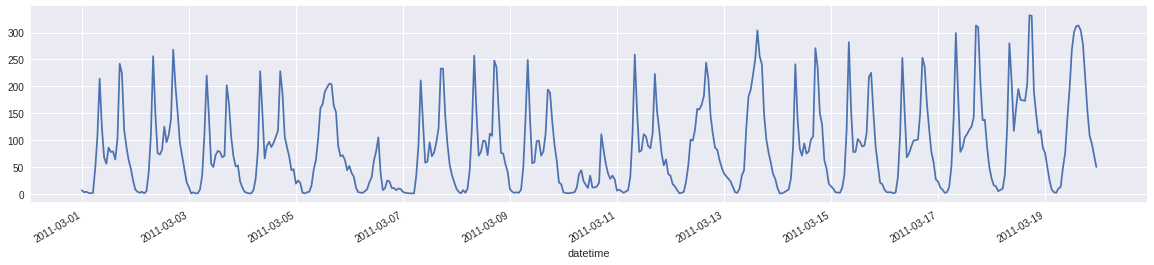

In [25]:
train["2011-03-01":"2011-03-21"].total.plot(figsize=(20,4))

Different behavior on weekdays and weekends:
* 2 peak on weekdays: morning and afternoon
* 1 peak on weekends in the middle of the day